In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch] # convert char to index
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% 
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices 

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 + b1           # hidden layer pre-activation
    h = torch.tanh(h_pre_act)               # hidden layer
    logits = h @ W2 + b2                    # output layer    
    loss = F.cross_entropy(logits, Yb)      # loss function
    
    # Backward pass
    for p in parameters:    
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item()) 

      0/ 200000: 27.8817
  10000/ 200000: 2.7955
  20000/ 200000: 2.6306
  30000/ 200000: 2.8458
  40000/ 200000: 2.0263
  50000/ 200000: 2.5424
  60000/ 200000: 2.3461
  70000/ 200000: 2.1167
  80000/ 200000: 2.3299
  90000/ 200000: 2.2775
 100000/ 200000: 2.0110
 110000/ 200000: 2.2857
 120000/ 200000: 1.8496
 130000/ 200000: 2.3583
 140000/ 200000: 2.1619
 150000/ 200000: 2.2178
 160000/ 200000: 2.0732
 170000/ 200000: 1.7830
 180000/ 200000: 1.9616
 190000/ 200000: 1.9436


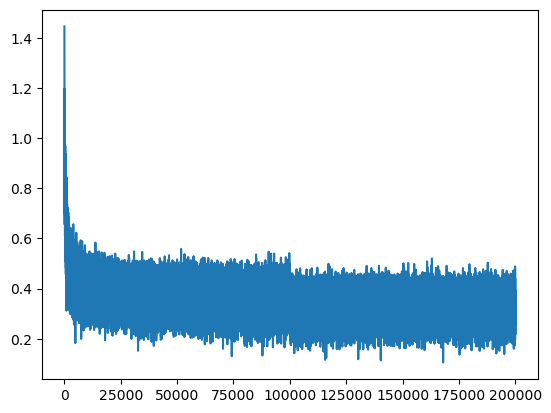

In [8]:
plt.plot(loss_i)

In [9]:
@torch.no_grad()    # temporarily turns off gradient computation for the next function
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)                        
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h = torch.tanh(emb_cat @ W1 + b1)       # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1277637481689453
val 2.1674869060516357


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) because it's 1 example being generated, every forward pass adds a prediction until . is hit
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample from predicted probability distribution over the characters
      context = context[1:] + [ix] # shift context
      out.append(ix) # append index of predicted character
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # convert indices to characters and print

mona.
mayah.
seel.
nah.
yal.
rener.
jendraegustered.
eliia.
milopaleigh.
eson.
arleitzion.
kamin.
shubergian.
jest.
jair.
jenslen.
profio.
zey.
der.
yarue.


In [11]:
# Issues: 

# 1) The loss at initialization is not appropriate:
#    first 10k training steps loss:
#                     0/ 200000: 27.8817
#                     10000/ 200000: 2.7955
# 
#  We expect the model to predict all characters with equal probability when it hasn't learned
#  anything yet. This means a p of 1/27.0. And the associated loss is:
print(f'{-torch.tensor(1/27.0).log() = }')

# Note: if instead we correctly initialize the weights (around 0 but with some entropy to break symmetry) and biases (to 0),
#       the first 10k iterations can be used to actually learn something, yielding better performance of the NN after all training is done.

# 2) if too many activations fed into the tanh are too large, the tanh will respond in the same way (with -1 or 1, remember tanh graph), 
#    this causes gradients to vanish, which can result in dead neurons that never learn (their weights and biases are never learning)! 
#       Remember summary of grad calc Steps:
#           Compute the forward pass with y = tanh(x).
#           During backpropagation, receive the gradient of the loss with respect to the output of the tanh function, dL/dy.
#           Compute the derivative of the tanh function: dy/dx = 1 - tanh^2(x) = 1 - y^2.
#           Apply the chain rule: dL/dx = dL/dy * (1 - y^2).
#    https://www.youtube.com/watch?v=P6sfmUTpUmc&t=144s (00:12:59 - 00:27:53)

-torch.tensor(1/27.0).log() = tensor(3.2958)


### Distributions optimization

In [12]:
# Initialize
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# In modern NNs the most practical initialization is gain to ensure normal distribution of parameters is sqrt(fan_in) with fan_in being the number of
# inputs.

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # Kaiming initialization
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0  

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [13]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices 

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 + b1           # hidden layer pre-activation
    h = torch.tanh(h_pre_act)               # hidden layer
    logits = h @ W2 + b2                    # output layer    
    loss = F.cross_entropy(logits, Yb)      # loss function
    
    # Backward pass
    for p in parameters:    
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item()) 

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


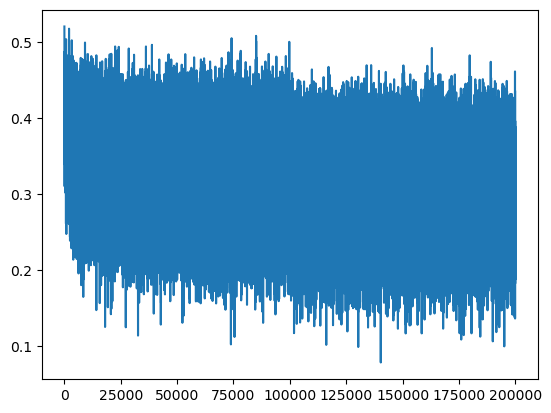

In [14]:
plt.plot(loss_i)

In [15]:
@torch.no_grad()    # temporarily turns off gradient computation for the next function
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)                        
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h = torch.tanh(emb_cat @ W1 + b1)       # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# Note: Loss is much better.

train 2.0376641750335693
val 2.106989622116089


## Batch Norm

In [16]:
# Initialize
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size**0.5)) # Kaiming initialization

# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# Note: μ = mean(W * x) + b 
#       Thus, the bias b directly shifts the mean of the pre-activation output z by b. This is important because when we subtract the mean μ during 
#       BatchNorm, we effectively remove this shift. Therefore, the batch norm biases (which are per neuron) can take on the role of neuron biases.
#       
#       BatchNorm scaling: z_BN(i,j) = γ_j * z_hat(i, j) + β_j     ,     with i = ith batch sample and j = jth neuron.
#
#       On the other hand, The scaling factor γ (gamma) in BatchNorm does not replace the weights W because they serve different purposes. The weights 
#       W learn the relationships between inputs and outputs (i.e., the core pattern learning in the network), while 
#       γ adjusts the scale of the output after normalization to ensure effective training without interfering with the weights' role in 
#       learning features. (biases are 1 per neuron, just like in BatchNorm, but weights are n_inputs per neuron, unlike the scaling factor γ,
#       which is 1 per neuron as well. Remember W is a matrix and b a vector.).

W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0  

bngain = torch.ones(1, n_hidden)  # Batch norm parameters. Through these, the NN can have the freedom to learn how to best shape its preactivation 
                                  # distributions.
bnbias = torch.zeros(1, n_hidden)  # The important thing is that, at initialization, the preactivations are all normalized.

bnmean_running = torch.zeros(1, n_hidden)   # Tracking instead of calculating them over the whole training set at the end
bnstd_running = torch.ones(1, n_hidden)     # Initialized to 1s since h_pre_act will be roughly unit gaussian as per initialization

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [17]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices 

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 # + b1           # hidden layer pre-activation

    # Batch norm layer.
    # ------------------------------------------------------------------------------------------------------------------------------
    bnmeani = h_pre_act.mean(0, keepdim=True)
    bnstdi = h_pre_act.std(0, keepdim=True)

    h_pre_act = bngain * ((h_pre_act - bnmeani) / bnstdi) + bnbias # bnbias takes on the function of the neuron biases.

    with torch.no_grad():   # Tell pytorch these are not to be backprop through and should not be added to the computational graph.
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ------------------------------------------------------------------------------------------------------------------------------
    h = torch.tanh(h_pre_act)               # hidden layer
    logits = h @ W2 + b2                    # output layer    
    loss = F.cross_entropy(logits, Yb)      # loss function
    
    # Backward pass
    for p in parameters:    
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item()) 

      0/ 200000: 3.3239
  10000/ 200000: 2.1029
  20000/ 200000: 2.5859
  30000/ 200000: 1.9663
  40000/ 200000: 2.2720
  50000/ 200000: 1.7952
  60000/ 200000: 2.1208
  70000/ 200000: 2.3775
  80000/ 200000: 2.4205
  90000/ 200000: 2.0829
 100000/ 200000: 2.3486
 110000/ 200000: 2.3512
 120000/ 200000: 1.6859
 130000/ 200000: 1.9948
 140000/ 200000: 2.2430
 150000/ 200000: 2.0044
 160000/ 200000: 2.0956
 170000/ 200000: 2.4032
 180000/ 200000: 2.0609
 190000/ 200000: 2.0705


In [18]:
h_pre_act.mean(0, keepdim=True).shape # mean and std are calculated PER NEURON!

torch.Size([1, 200])

In [19]:
# Problem: The NN now expects batches so it can compute batch statistics, but at inference time we might want just one output.

# Therefore, we estimate bnmean and bnstd at the end, and these values will be used at inference time.

# with torch.no_grad():
    # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     h_pre_act = embcat @ W1 + b1

    # Measure the traning set mean and std (remember emb was taken from the whole Xtr)
#     bnmean = h_pre_act.mean(0, keepdim=True) 
#     bnstd = h_pre_act.std(0, keepdim=True)

# But in a better way, we can instead just keep track of the mean and std as we train.

In [20]:
@torch.no_grad()    # Temporarily turns off gradient computation for the next function.
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)                        
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h_pre_act = emb_cat @ W1 # + b1           # (N, n_hidden)

    h_pre_act = bngain * ((h_pre_act - bnmean_running) / bnstd_running) + bnbias # Batch norm layer with running statistics for inference

    h = torch.tanh(h_pre_act)               # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0596511363983154
val 2.1066300868988037


In [21]:
print(f'{emb.shape = }, \n{emb_cat.shape = }, \n{W1.shape = }, \n{h_pre_act.shape = }, \n{h.shape = }, \n{logits.shape = }')

emb.shape = torch.Size([32, 3, 10]), 
emb_cat.shape = torch.Size([32, 30]), 
W1.shape = torch.Size([30, 200]), 
h_pre_act.shape = torch.Size([32, 200]), 
h.shape = torch.Size([32, 200]), 
logits.shape = torch.Size([32, 27])


## Code cleanup with classes and functions

In [51]:
class Linear: 

    def __init__(self, fan_in: int, fan_out: int, bias: bool =True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None # (means if bias == True else None)
    
    def __call__(self, x: torch.tensor) -> torch.tensor:    # Special method that allows an instance of a class to be called like a function.
        self.out = x @ self.weight
        if self.bias is not None:   # The 'is' and 'is not' operators check object identity, meaning they determine whether two references point to 
                                    # the exact same object in memory.

                                    # == and !=, on the other hand, check object equality, meaning they determine whether the values of two 
                                    # objects are equal, regardless of whether they are the same object in memory.
            self.out += self.bias
        return self.out
    
    def parameters(self) -> list:
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-05, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x: torch.tensor) -> torch.tensor:
        # Forward pass
        if self.training:
            xmean = x.mean(0, keepdim= True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self) -> list:
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self) -> list:
        return []
        
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn(vocab_size, n_embd,                 generator=g) # random embeds

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),  # (10*3, 100)
    Linear(           n_hidden, n_hidden), Tanh(),  # (100, 100)
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),        # (100, 27)
]

with torch.no_grad():
    # Last layer: make less confident (remember that multiplication and division affect the variance of a distribution through compression or expansion)
    layers[-1].weight *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

46497


In [52]:
# Training

max_steps = 200000
batch_size = 32
loss_i = []

update_data_ratio = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # Batch X,Y of char indices 

    # Forward pass
    emb = C[Xb]                     # Embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # Concatenate the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)   # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()     # Tell Pytorch to retain the gradients

    for p in parameters:    
        p.grad = None

    loss.backward()

    # Update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        update_data_ratio.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # For debugging

      0/ 200000: 3.2962


## Visualizations

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


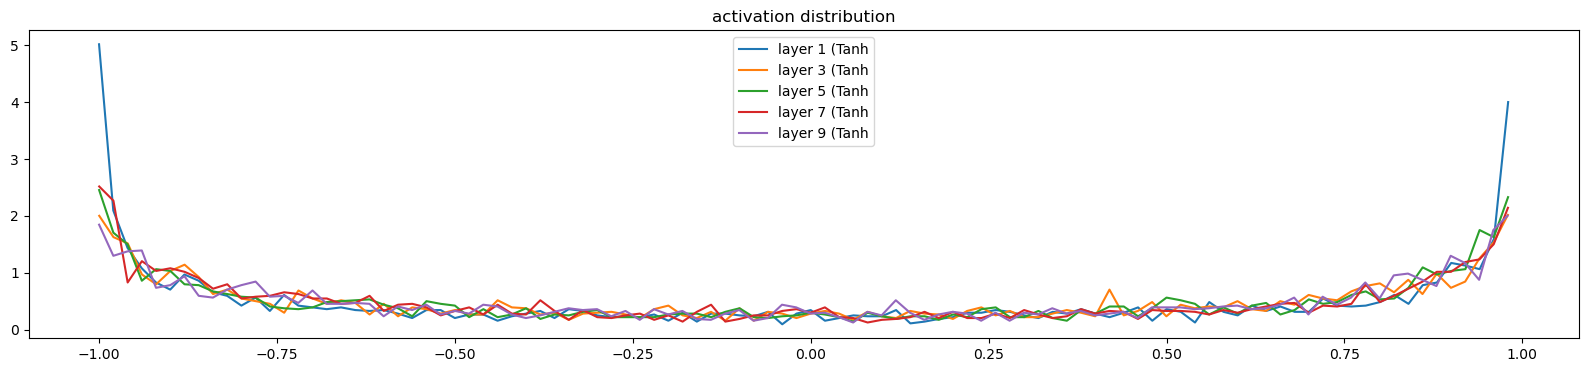

In [53]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # Use enumerate so you can use the index of each layer and exclude the last layer.
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' 
              % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)) # C-style string formatting.
        # __class__ returns the class object (verbose), __name__ returns the class name as a string.
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);    # ; used to skip unwanted output
plt.title('activation distribution');

# Note: The tanh functions compress the distributions of the activations. Multiple tanh layers then keep compressing the standard deviation of the distribution of activations,
# as the tanh function is almost linear near 0 but not fully, so it keeps mapping the values to smaller ones, leading to a convergence to 0.
# The 5/3 factor is used to fight against this compression.

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


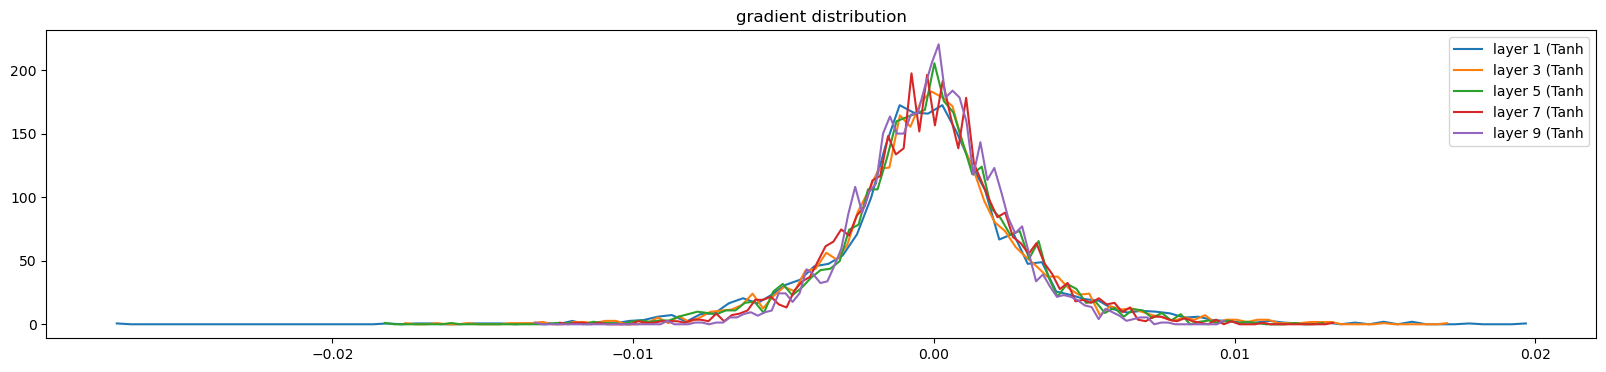

In [54]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000980 | std 1.189170e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214556e-02
weight (100, 100) | mean +0.000033 | std 7.821213e-03 | grad:data ratio 4.653363e-02
weight (100, 100) | mean -0.000107 | std 6.655619e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086039e-03 | grad:data ratio 3.605767e-02
weight (100, 100) | mean -0.000077 | std 5.075619e-03 | grad:data ratio 3.015268e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


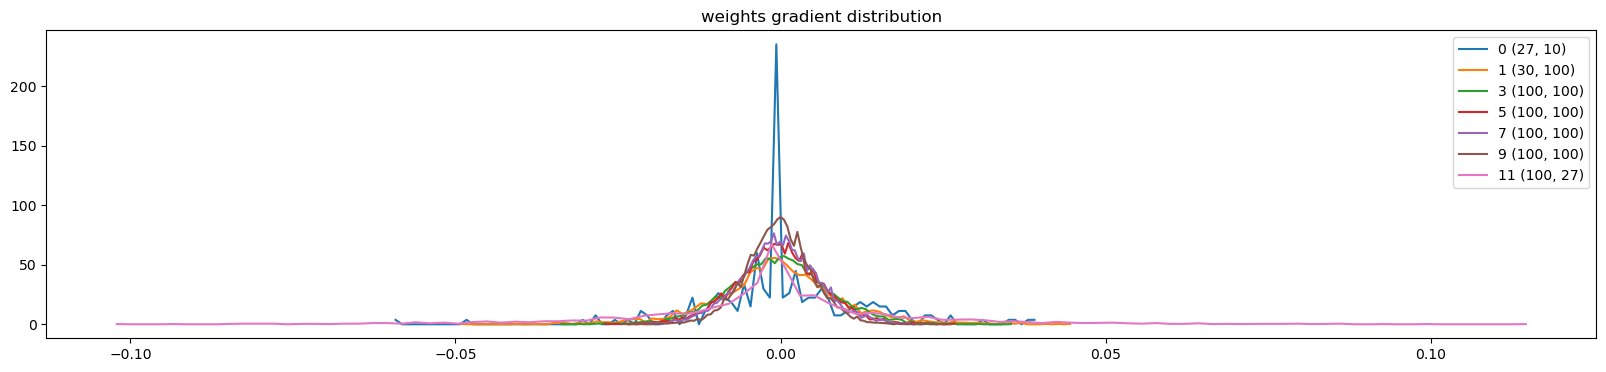

In [55]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # Restricting to only the W matrices
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' 
          % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

# Note: the std of the last layer is much larger than the ones from the other layers

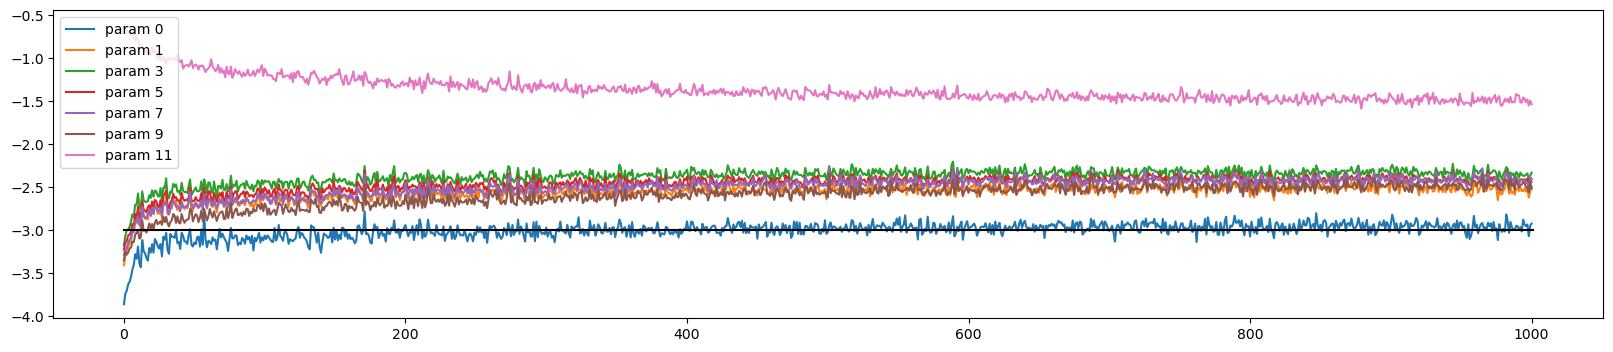

In [56]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
    legends.append('param %d' % i)
plt.plot([0, len(update_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicated on plot w/ black line
plt.legend(legends);

# Note: This is a measure of how the NN is learning (too fast or too slow). AIM FOR 1e-3!

## With batchnorm layers

In [63]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1         # Now, the code applies batch normalization, and gamma is essentially taking over the role of controlling the scale of the outputs for that layer.
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [64]:
# Training

max_steps = 200000
batch_size = 32
loss_i = []

update_data_ratio = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # Batch X,Y of char indices 

    # Forward pass
    emb = C[Xb]                     # Embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # Concatenate the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)   # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()     # Tell Pytorch to retain the gradients

    for p in parameters:    
        p.grad = None

    loss.backward()

    # Update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        update_data_ratio.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # For debugging

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


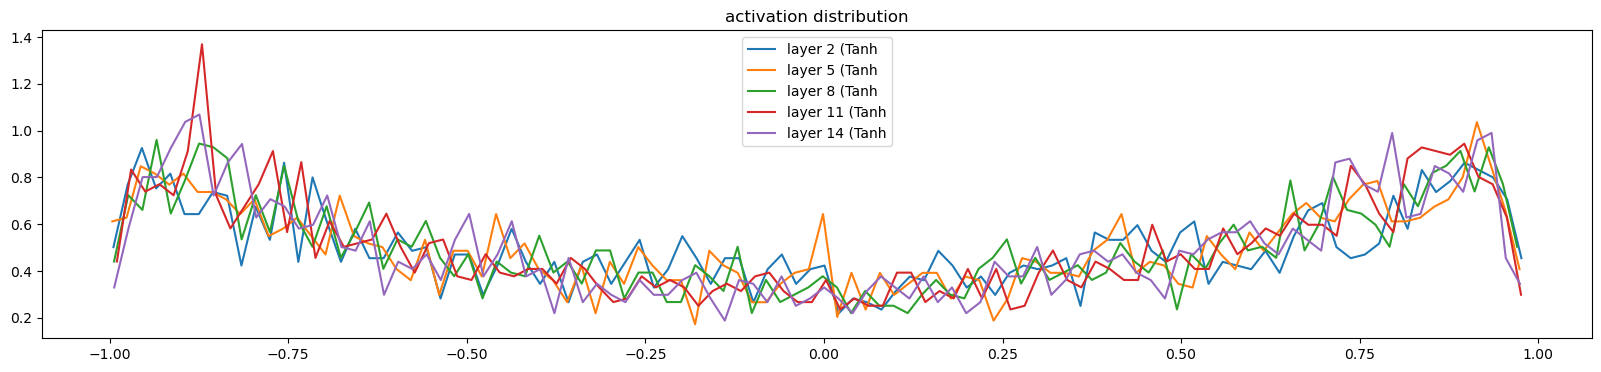

In [65]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # Use enumerate so you can use the index of each layer and exclude the last layer.
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' 
              % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)) # C-style string formatting.
        # __class__ returns the class object (verbose), __name__ returns the class name as a string.
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);    # ; used to skip unwanted output
plt.title('activation distribution');

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


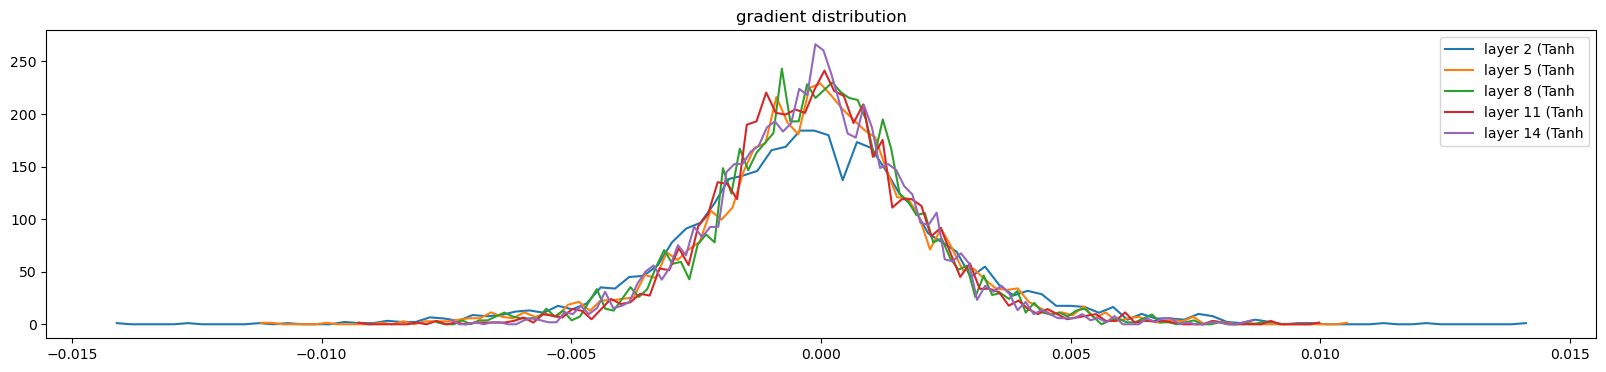

In [66]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 8.020534e-03 | grad:data ratio 8.012630e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132875e-03 | grad:data ratio 6.964616e-02
weight (100, 100) | mean -0.000086 | std 6.234300e-03 | grad:data ratio 6.073736e-02
weight (100, 100) | mean +0.000052 | std 5.742183e-03 | grad:data ratio 5.631479e-02
weight (100, 100) | mean +0.000032 | std 5.672203e-03 | grad:data ratio 5.570124e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160104e-01


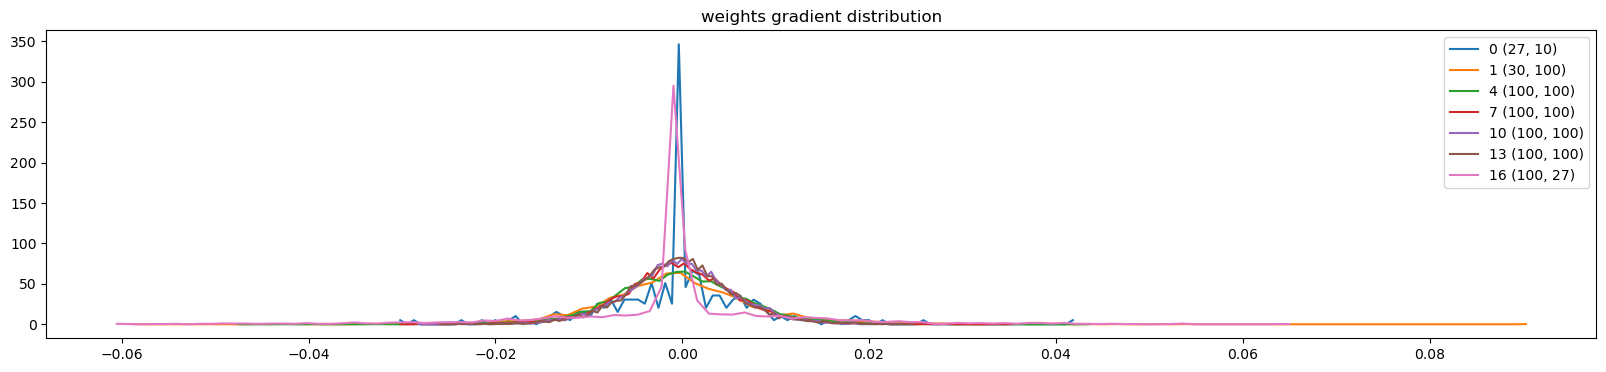

In [67]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # Restricting to only the W matrices
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' 
          % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

# Note: the std of the last layer is much larger than the ones from the other layers

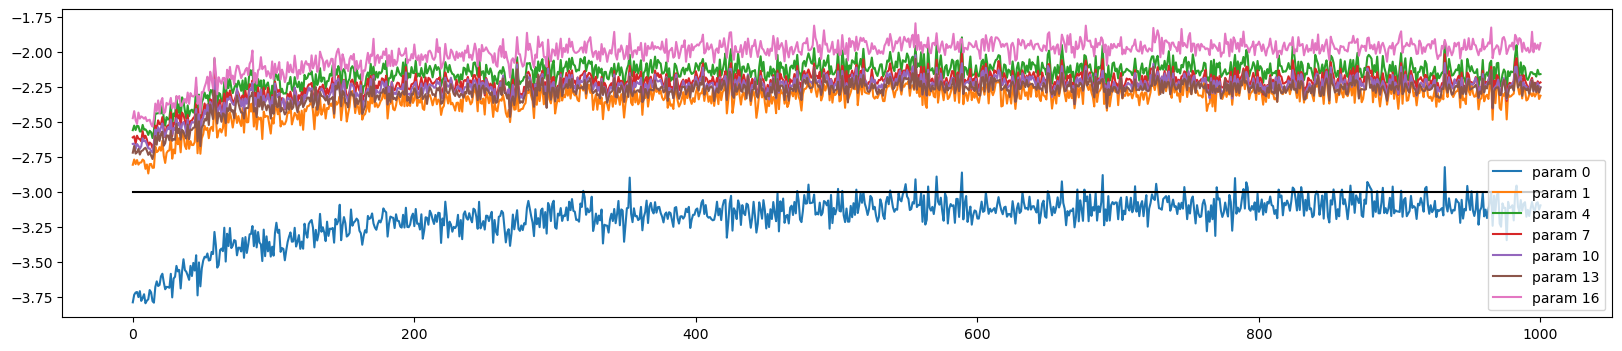

In [68]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
    legends.append('param %d' % i)
plt.plot([0, len(update_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicated on plot w/ black line
plt.legend(legends);

# Note: This is a measure of how the NN is learning (too fast or too slow). AIM FOR 1e-3!

In [69]:
# Notes:

# 1) Using batchNorm, we are more robust to the gains applied to the layers for initialization (Kaiming initialization / gain), but we need to still be careful with the lr to
#    make sure that all weights are learning at similar rates and at an update_data_ratio of around 1e-3 in the log10 scale.